In [2]:
%autosave 0
import sys
sys.dont_write_bytecode = True
dropbox_path = '/home/tim/Dropbox/'
sys.path.append(dropbox_path)
from commands.setup import *
from astar import *
instance_name, dropbox_path, local_path, data_path, models_path = setup(dropbox_path=dropbox_path)
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())
import copy

Autosave disabled


In [11]:
resolution = 1

airsim_map = 'Blocks'
motion = '2d'
z_level = 4
region = 'test'

read_map = True
make_dict = False
write_map = False

dataset = airsim_map + '_' + motion + '_' + region
paths_folder = data_path + 'astar_paths/32m/'
print(dataset)

Blocks_2d_test


there are 3 change of axis to display the roof top heat map below.
1. AirSim uses yx(-z) coordinates
2. Voxels outputs data in real world Unity xyz coordinates, inputting airsim coordinats
3. plt.imshow(2d-array) plots the second dimension along the horizontal and first along the vertical

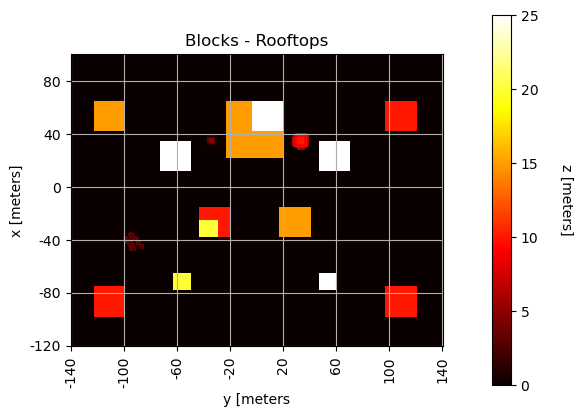

In [12]:
gridpath_airsim = data_path + 'grids/grid_airsim_' + airsim_map + '.p'
gridpath_unity = data_path + 'grids/grid_unity_' + airsim_map + '.p'
roofpath_airsim = data_path + 'rooftops/rooftops_airsim_' + airsim_map + '.p'
roofpath_unity = data_path + 'rooftops/rooftops_unity_' + airsim_map + '.p'

if airsim_map in ['AirSimNH']:
    xrange, yrange, zrange = [-240, 240], [-240, 240], [-10, 40] # unity world coordinates
    x_shift, y_shift = 240, 240
if airsim_map in ['Blocks']:
    xrange, yrange, zrange = [-140, 140], [-120, 100], [-10, 30] # unity world coordinates
    x_shift, y_shift = 120, 140

if read_map:
    grid_airsim = pickle.load(open(gridpath_airsim, 'rb'))
    grid_unity = pickle.load(open(gridpath_unity, 'rb'))
    rooftops_airsim = pickle.load(open(roofpath_airsim, 'rb'))
    rooftops_unity = pickle.load(open(roofpath_unity, 'rb'))
    
else:

    if airsim_map in ['AirSimNH']:
        airsimnh_topleft = Voxels('voxels/airsimnh_topleft.binvox', floor=104, xmin=-250, ymin=0, zmin=-125) # unity world coords
        airsimnh_topright = Voxels('voxels/airsimnh_topright.binvox', floor=104, xmin=0, ymin=0, zmin=-125) # unity world coords
        airsimnh_botleft = Voxels('voxels/airsimnh_botleft.binvox', floor=104, xmin=-250, ymin=-250, zmin=-125) # unity world coords
        airsimnh_botright = Voxels('voxels/airsimnh_botright.binvox', floor=104, xmin=0, ymin=-250, zmin=-125) # unity world coords
        
        grid_unity = combine_voxels([
            airsimnh_topleft, airsimnh_topright, airsimnh_botleft, airsimnh_botright
        ], xrange, yrange, zrange, 1) # unity world coords

    if airsim_map in ['Blocks']:
        blocks_left = Voxels('voxels/blocks_left.binvox', floor=104, xmin=-250, ymin=-125, zmin=-125) # unity world coords
        blocks_right = Voxels('voxels/blocks_right.binvox', floor=104, xmin=0, ymin=-125, zmin=-125) # unity world coords
        grid_unity = combine_voxels([blocks_left, blocks_right], xrange, yrange, zrange, 1)
    
    grid_airsim = unity_to_airsim(grid_unity) # unity to airsim world coords
    rooftops_airsim = grid_to_rooftops(grid_airsim, roof=-1*zrange[1], floor=-1*zrange[0], delta_z=-1, buffer=1, minmax='min')
    rooftops_unity = grid_to_rooftops(grid_unity, roof=zrange[1], floor=zrange[0], delta_z=1, buffer=1, minmax='max')
    
rooftops = rooftops_unity #rooftops_airsim

#if make_dict:
rooftops_dict_airsim = {} # airsim
for i in range(len(rooftops)):
    x = i + xrange[0] 
    for j in range(len(rooftops[i])):
        y = j + yrange[0]
        if y not in rooftops_dict_airsim:
            rooftops_dict_airsim[y] = {}
        rooftops_dict_airsim[y][x] = -1*rooftops[i][j]
    #pk_write(rooftops_dict_airsim, 'rooftops_dict_airsim.p')

if write_map:
    pickle.dump(grid_airsim, open(gridpath_airsim, 'wb'))
    pickle.dump(grid_unity, open(gridpath_unity, 'wb'))
    pickle.dump(rooftops_airsim, open(roofpath_airsim, 'wb'))
    pickle.dump(rooftops_unity, open(roofpath_unity, 'wb'))
    
if airsim_map in ['AirSimNH']:
    interval = 80
if airsim_map in ['Blocks']:
    interval = 40

plt.imshow(rooftops.T, cmap='hot', interpolation='nearest', origin='lower')
cbar = plt.colorbar(pad=0.1)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('z [meters]', rotation=270)

plt.title(f'{airsim_map} - Rooftops')
plt.xticks([i for i in range(0, len(rooftops), interval)], 
          [xrange[0] + i for i in range(0, len(rooftops), interval)], rotation=90)
plt.yticks([i for i in range(0, len(rooftops[0]), interval)], 
          [yrange[0] + i for i in range(0, len(rooftops[0]), interval)])
plt.ylabel('x [meters]')
plt.xlabel('y [meters')
plt.grid()
plt.show()

In [13]:
# divides euclidean distance from start to end by total euclidean distance traveled
def calc_nonlinearity_v1(path):
    linearity = np.linalg.norm(path[-1]['position']-path[0]['position'])
    travel_distance = np.sum([np.linalg.norm(path[i+1]-path[i]) for i in range(len(path)-1)])
    nonlinearity = travel_distance/linearity
    return nonlinearity

# calculates percent of pixels with an object in them,
    # between start and end
def calc_nonlinearity_v2(path):
    start = path[0]['position']
    end = path[-1]['position']
    left0 = min(start[0], end[0])
    right0 = max(start[0], end[0]) + 1
    left1 = min(start[1], end[1])
    right1 = max(start[1], end[1]) + 1
    chunk = rooftops[left0:right0, left1:right1]
    blocked = chunk > 0
    n_cubes = chunk.size
    if(n_cubes <= 0):
        print(left0, right0, left1, right1, chunk, path)
    nonlinearity = np.sum(blocked) / n_cubes
    return nonlinearity

# returns the number of rotations in path 
     # proxy to number of objects in the way
def calc_nonlinearity_v3(path):
    not_forward = 0
    for point_idx, point in enumerate(path):
        action = point['action']
        if action not in [-1,2,3,4,5,6]:
            not_forward += 1
    return not_forward

def calc_linearity_v1(path):
    return np.linalg.norm(np.array(path[-1]['position'])-np.array(path[0]['position']))
    
calc_linearity = calc_linearity_v1
calc_nonlinearity = calc_nonlinearity_v3

number of total paths = 21686


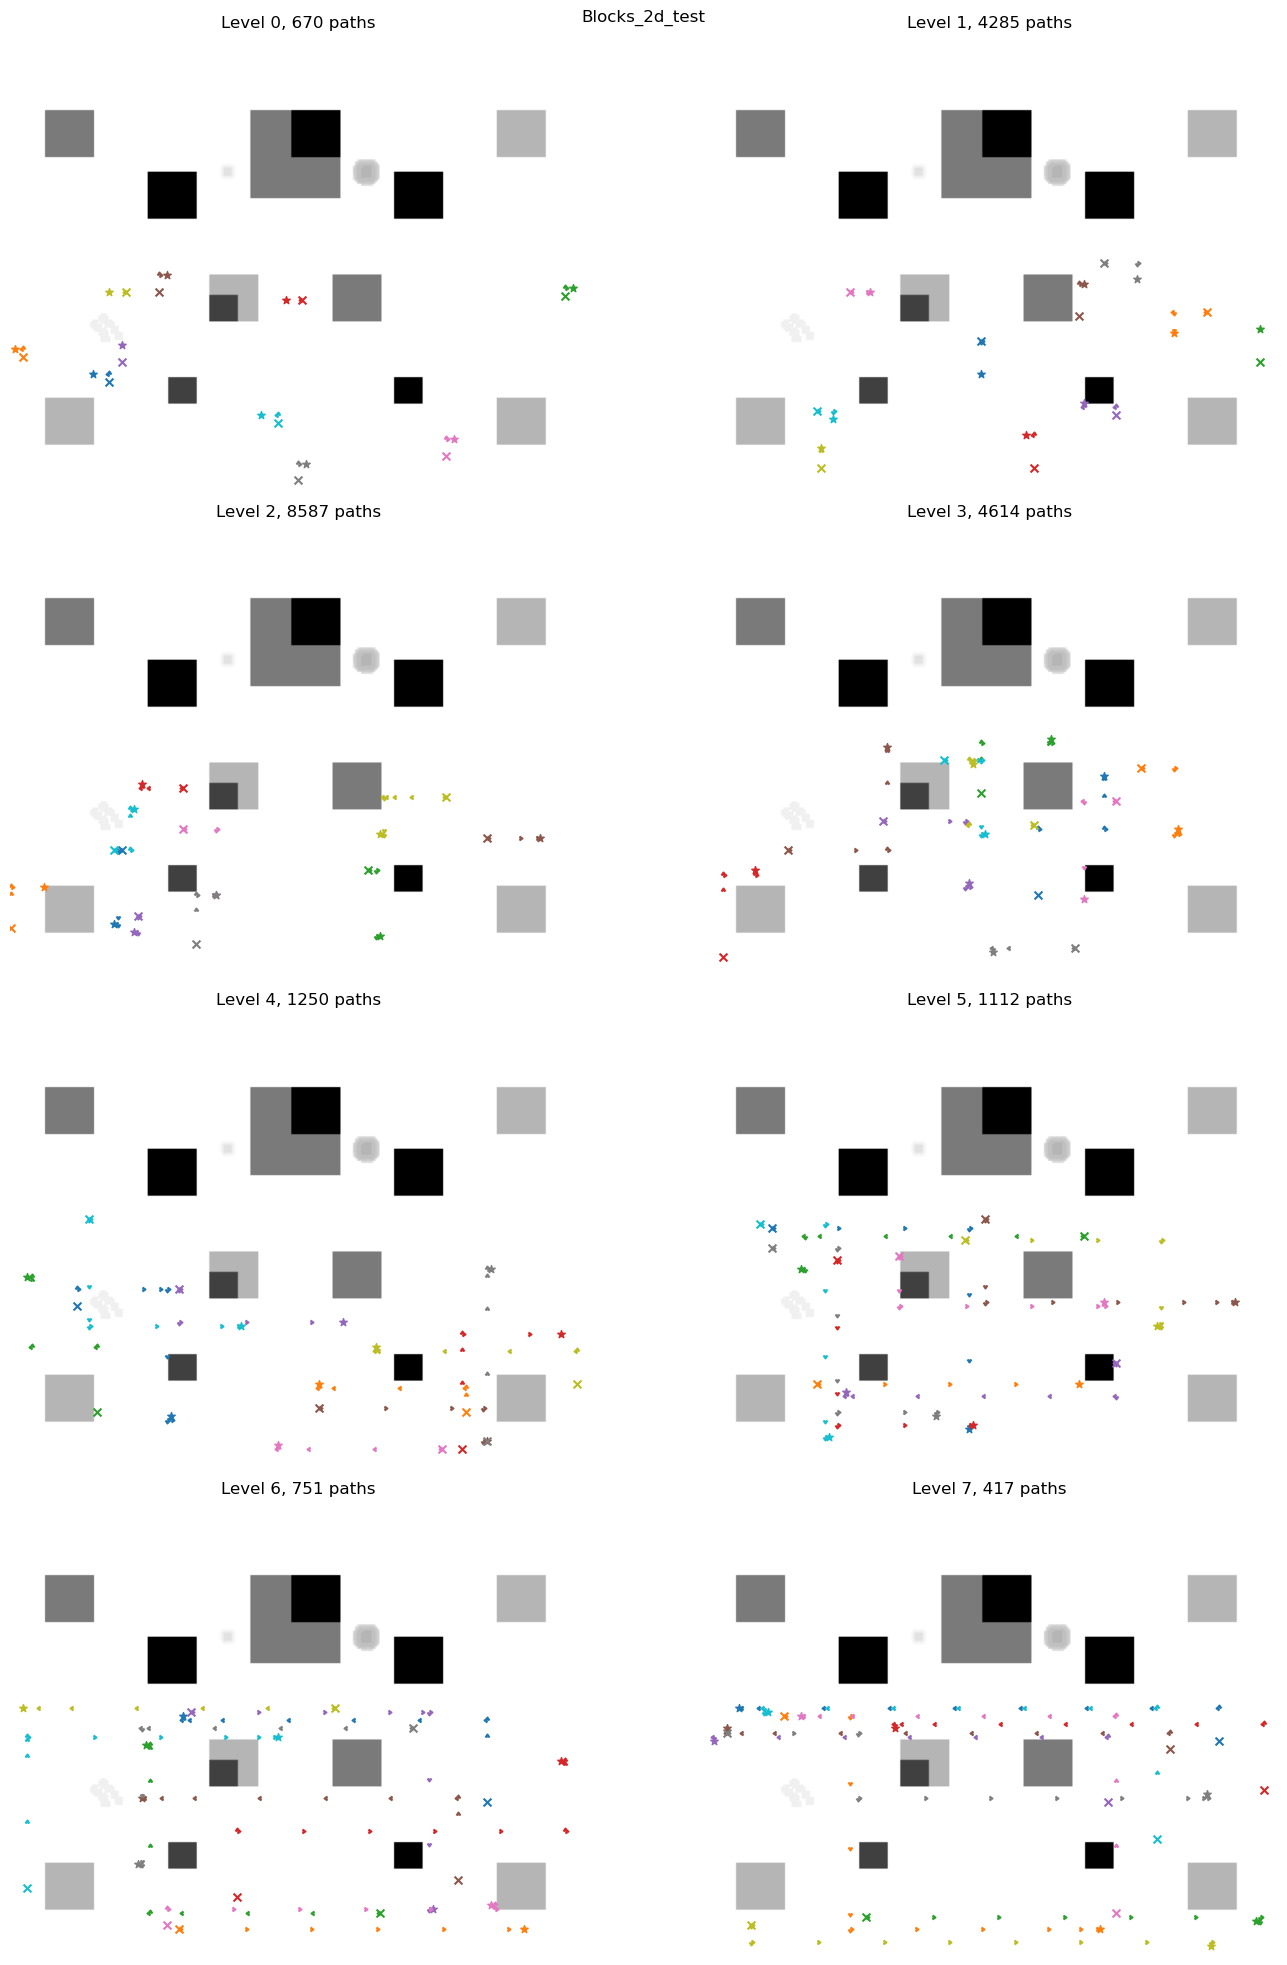

In [14]:
visited = {}
# read paths
paths = []
#if os.path.exists(data_path + 'paths/' + dataset + '.p'):
#    paths = pk_read(data_path + 'paths/' + dataset + '.p')['paths']
collect_here = f'{paths_folder}collect/'
identifier_names = os.listdir(collect_here)
for identifier_name in identifier_names:
    if airsim_map in identifier_name and motion in identifier_name and region in identifier_name:
        these_paths = pickle.load(open(collect_here + identifier_name, 'rb'))
        paths = paths + these_paths

# get path linearity and nonlinearity
nonlinearitys = []
linearitys = []
for path in paths:
    linearity = calc_linearity(path)
    nonlinearity = calc_nonlinearity(path)
    linearitys.append(linearity)
    nonlinearitys.append(nonlinearity)

#    n_levels = 8
linearity_min, linearity_max = float(np.min(linearitys)), float(np.max(linearitys))
nonlinearity_min, nonlinearity_max = float(np.min(nonlinearitys)), float(np.max(nonlinearitys))
#    delta_linearity = (linearity_max - linearity_min ) / n_levels
#    delta_nonlinearity = (nonlinearity_max - nonlinearity_min ) / n_levels
#    level_ranges = [[
#        linearity_min+delta_linearity*i,
#        linearity_min+delta_linearity*(i+1),
#        nonlinearity_min+delta_nonlinearity*i,
#        nonlinearity_min+delta_nonlinearity*(i+1)
#    ] for i in range(n_levels)]

min_linearity = 5
level_ranges = [
    [min_linearity,10,0,1.1],
    [10,20,2,2.1],
    [20,40,3,3.1],
    [40,70,4,4.1],
    [70,100,5,5.1],
    [100,140,6,6.1],
    [140,180,7,7.1],
    [180,np.inf,8,np.inf],
]
n_levels = len(level_ranges)

level_paths = []
level_linearitys = []
level_nonlinearitys = []
n_total_paths = 0
for level in range(n_levels):
    level_paths.append([])
    level_linearitys.append([])
    level_nonlinearitys.append([])
    linearity_lower, linearity_upper, nonlinearity_lower, nonlinearity_upper = level_ranges[level]
    for pi in range(len(paths)-1,-1,-1):
        path = paths[pi]
        linearity = calc_linearity(path)
        nonlinearity = calc_nonlinearity(path)
        # check if in bounds of lower and upper vals
        if linearity < min_linearity:
            continue
        if linearity >= linearity_upper:
            continue
        if nonlinearity >= nonlinearity_upper:
            continue
        if linearity >= linearity_lower or nonlinearity >= nonlinearity_lower:
            # dont add copies
            start = path[0]['position']
            end = path[-1]['position']
            key = str(start+end)
            if key in visited:
                continue
            level_paths[level].append(path.copy())
            level_linearitys[level].append(linearity)
            level_nonlinearitys[level].append(nonlinearity)
            visited[key] = True
            n_total_paths += 1
            del paths[pi]
    
# sample some paths from each level and view
print('number of total paths =', n_total_paths)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
for level in range(n_levels):
    #print(f'number of paths at level {level} = {len(level_paths[level])}')
    ax = axs[int((level)/2), (level)%2]
    ax.set_title('Level ' + str(level) + ', ' + str(len(level_paths[level])) + ' paths')
    ax.set_aspect('equal')
    ax.axis("off")
    ax.imshow(rooftops.T, cmap='Greys', origin='lower')
    these_paths = random.sample(level_paths[level], min(10, len(level_paths[level])))
    for path_idx, path in enumerate(these_paths):
        # plot path
        ax.scatter(path[0]['position'][0], path[0]['position'][1], marker='x', color=colors[path_idx], s=32)
        ax.scatter(path[-1]['position'][0], path[-1]['position'][1], marker='*', color=colors[path_idx], s=32)
        #ax.scatter(path[0]['position'][1]+y_shift, path[0]['position'][0]+x_shift, marker='x', color=colors[path_idx], s=32)
        #ax.scatter(path[-1]['position'][1]+y_shift, path[-1]['position'][0]+x_shift, marker='*', color=colors[path_idx], s=32)
        for point_idx, point in enumerate(path[1:-1]):
            marker = 10
            if point['direction'] == 1:
                marker = 9
            elif point['direction'] == 2:
                marker = 11
            elif point['direction'] == 3:
                marker = 8
            ax.scatter(point['position'][0], point['position'][1], color=colors[path_idx], s=8, marker=marker)
            #ax.scatter(point['position'][1]+y_shift, point['position'][0]+x_shift, color=colors[path_idx], s=8, marker=marker)
fig.suptitle(dataset)
plt.tight_layout()
plt.show()

In [15]:
linearity_subdelta = 5
nonlinearity_subdelta = 1
n_linearitys = math.ceil((linearity_max) / linearity_subdelta)+1
n_nonlinearitys = math.ceil((nonlinearity_max) / nonlinearity_subdelta)+2
linearity_bounds = [linearity_subdelta*i for i in range(n_linearitys)]
nonlinearity_bounds = [nonlinearity_subdelta*i for i in range(n_nonlinearitys)]

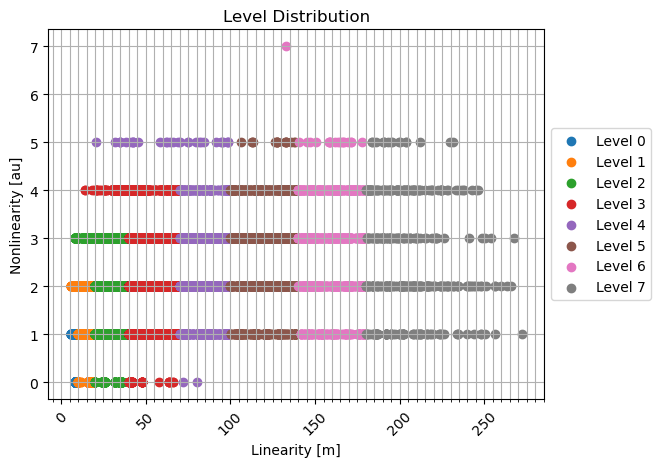

In [16]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots()
for level in range(n_levels):
    these_linearitys = level_linearitys[level]
    these_nonlinearitys = level_nonlinearitys[level]
    ax.scatter(these_linearitys, these_nonlinearitys, label='Level ' + str(level))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Level Distribution')
ax.set_xlabel('Linearity [m]')
ax.set_ylabel('Nonlinearity [au]')
xt = ax.get_xticks()[1:-1]
yt = ax.get_yticks()[1:-1]
ax.xaxis.set_minor_locator(MultipleLocator(linearity_subdelta))
ax.yaxis.set_minor_locator(MultipleLocator(nonlinearity_subdelta))
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle='-')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [8]:
# aggregate
paths_info = {
    'paths':[],
    'nonlinearitys':[],
    'linearitys':[],
    'levels':{},
    'idx_levels':[],
    'idx_sublevels':[],
}
        
for level in range(n_levels):
    print('LEVEL', level)
    paths_info['levels'][level] = []
    paths = level_paths[level]
    these_linearitys = np.array(level_linearitys[level])
    these_nonlinearitys = np.array(level_nonlinearitys[level])
    
    # place all paths into subsets
    for linearity_i in range(len(linearity_bounds)-1):
        linearity_left = linearity_bounds[linearity_i]
        linearity_right = linearity_bounds[linearity_i+1]
        for nonlinearity_i in range(len(nonlinearity_bounds)-1):
            nonlinearity_left = nonlinearity_bounds[nonlinearity_i]
            nonlinearity_right = nonlinearity_bounds[nonlinearity_i+1]
            linearity_idxs = np.where((these_linearitys>=linearity_left) & (these_linearitys<linearity_right))
            nonlinearity_idxs = np.where((these_nonlinearitys >= nonlinearity_left) & (these_nonlinearitys < nonlinearity_right))
            idxs = np.intersect1d(linearity_idxs, nonlinearity_idxs)
            if(len(idxs)) > 0:
                sublevel = len(paths_info['levels'][level])
                print('sublevel', sublevel)
                n_paths_b4 = len(paths_info['paths'])
                paths_info['paths'] = paths_info['paths'] + [paths[idx] for idx in idxs]
                paths_info['linearitys'] = paths_info['linearitys'] + [float(these_linearitys[idx]) for idx in idxs]
                paths_info['nonlinearitys'] = paths_info['nonlinearitys'] + [int(these_nonlinearitys[idx]) for idx in idxs]
                paths_info['levels'][level].append([n_paths_b4+i for i in range(len(idxs))])
                paths_info['idx_levels'] = paths_info['idx_levels'] + [level for i in range(len(idxs))]
                paths_info['idx_sublevels'] = paths_info['idx_sublevels'] + [sublevel for i in range(len(idxs))]
    
#cast to floats and to aisrsim coords
cast_paths = []
for path in paths_info['paths']:
    cast_path = []
    for point in path:
        cast_point = [0]*3
        cast_point[0] = float(point['position'][1]) + yrange[0] # change y to x
        cast_point[1] = float(point['position'][0]) + xrange[0] # change x to y
        cast_point[2] = -1*float(point['position'][2]) # negate z
        point['position'] = cast_point
        cast_path.append(point)
    cast_paths.append(np.array(cast_path))
paths_info['paths'] = cast_paths.copy()

LEVEL 0
sublevel 0
sublevel 1
LEVEL 1
sublevel 0
sublevel 1
sublevel 2
sublevel 3
sublevel 4
sublevel 5
sublevel 6
LEVEL 2
sublevel 0
sublevel 1
sublevel 2
sublevel 3
sublevel 4
sublevel 5
sublevel 6
sublevel 7
sublevel 8
sublevel 9
sublevel 10
sublevel 11
sublevel 12
sublevel 13
sublevel 14
sublevel 15
sublevel 16
sublevel 17
sublevel 18
LEVEL 3
sublevel 0
sublevel 1
sublevel 2
sublevel 3
sublevel 4
sublevel 5
sublevel 6
sublevel 7
sublevel 8
sublevel 9
sublevel 10
sublevel 11
sublevel 12
sublevel 13
sublevel 14
sublevel 15
sublevel 16
sublevel 17
sublevel 18
sublevel 19
sublevel 20
sublevel 21
sublevel 22
sublevel 23
sublevel 24
sublevel 25
sublevel 26
sublevel 27
sublevel 28
sublevel 29
sublevel 30
sublevel 31
sublevel 32
sublevel 33
sublevel 34
sublevel 35
sublevel 36
LEVEL 4
sublevel 0
sublevel 1
sublevel 2
sublevel 3
sublevel 4
sublevel 5
sublevel 6
sublevel 7
sublevel 8
sublevel 9
sublevel 10
sublevel 11
sublevel 12
sublevel 13
sublevel 14
sublevel 15
sublevel 16
sublevel 17
sub

In [ ]:
paths_info['level_ranges'] = level_ranges
paths_info['linearity_bounds'] = linearity_bounds
paths_info['nonlinearity_bounds'] = nonlinearity_bounds
pickle.dump(paths_info, open(f'{paths_folder}{dataset}.p', 'wb'))

In [ ]:
dataset

# change paths to 2 meter forward motions

In [ ]:
# action map
actions = [
    'RotateRight90',
    'RotateLeft90',
    'MoveForward2',
    'MoveForward4',
    'MoveForward8',
    'MoveForward16',
    'MoveForward32',
    'MoveDownward4',
    'MoveUpward4',
]
forward_steps = [
    0, 0, 2, 4, 8, 16, 32, 0, 0,
]
paths_2m = []
old_paths = paths_info['paths']
def print_path(name, path):
    print(name)
    for point in path:
        print(point)
    print()
for old_path in old_paths:
    start = copy.deepcopy(old_path[0])
    target = copy.deepcopy(old_path[-1])
    new_path = [start]
    last_pos = start['position'].copy()
    for point in old_path[1:]:
        point = copy.deepcopy(point)
        action = point['action']
        # get only forward actions greater than 2 meters
        if action > 2 and action < 7:
            forward_step = forward_steps[action]
            direction = point['direction']
            for step_2m in range(int(forward_step/2)):
                if direction == 0:
                    last_pos[0] += 2
                if direction == 1:
                    last_pos[1] += 2
                if direction == 2:
                    last_pos[0] -= 2
                if direction == 3:
                    last_pos[1] -= 2
                new_point = copy.deepcopy(point)
                new_point['action'] = 2
                new_point['position'] = last_pos.copy()
                new_path.append(new_point)
        else:
            last_pos = point['position'].copy()
            new_path.append(point)
    #print_path('old_path', old_path)
    #print_path('new_path', new_path)
    #ini = input()
    paths_2m.append(np.array(new_path))

In [ ]:
paths_info['paths'] = paths_2m
os.makedirs(f'{data_path}paths_2m', exist_ok=True)
pickle.dump(paths_info, open(f'{data_path}paths_2m/{dataset}.p', 'wb'))

In [ ]:
counts = np.zeros((yrange[1] - yrange[0]+1, xrange[1] - xrange[0]+1))
for path in paths_info['paths']:
    for point in path:
        x, y, z = point['position']
        counts[int(y+y_shift), int(x+x_shift)] += 1
counts[counts == 0] = 0

In [ ]:
import matplotlib.colors as mcolors
plt.imshow(counts.T, origin='lower', norm=mcolors.LogNorm())